# SOFIA/FORCAST Galactic Center Photometry Notebook

## Preliminary Steps - Select file to use from config.py and load in required packages

In [18]:
#uncomment this to see the names of the different configurations that can be loaded in
from config import *

fieldlist=[]
for info in field._registry:
    fieldlist.append(info.name)
print('Names of available configurations for fields:, ', fieldlist)

mosaiclist=[]
for info in mosaic._registry:
    mosaiclist.append(info.name)
print('\nNames of available configurations for mosaics:, ', mosaiclist)

Names of available configurations for fields:,  ['Field01', 'Field02', 'Field03', 'Field04', 'Field05', 'Field06', 'Field07', 'Field08', 'Field09', 'Field10', 'Field11', 'Field12', 'Field13', 'Field14', 'Field15', 'Field16', 'Field17', 'Field18', 'Field19', 'Field20', 'Field21', 'Field22', 'Field23', 'Field24', 'Field25', 'Field26', 'Field27', 'Field28', 'Field29', 'Field30', 'Field31', 'Field32', 'Field33', 'Field34', 'Field35', 'Field36', 'Field37', 'Field38', 'Field39', 'Field40', 'Field41', 'Field42', 'Field43', 'Field44', 'Field45', 'Field46', 'Field47', 'Field48', 'Field49', 'Field50', 'Field51', 'Field52']

Names of available configurations for mosaics:,  ['Mosaic25', 'Mosaic37']


In [19]:
#import configuration for selected file
from config import Field28 as field
from config import dpath, dpathalt, ds9path #import additional common paramters

In [20]:
wvlist=[]
for info in wv._registry:
    wvlist.append(info.name)
print('\nNames of available configurations for wavelength filters:, ', wvlist)


Names of available configurations for wavelength filters:,  ['F252', 'F371']


In [21]:
#import filter configuration - change F252 to F371 if desired (or define your own filter parameters in config.py)
from config import F252 as filt

#rename a few parameters that were just imported. 
bkgbox=filt.bkgbox
radii=filt.radii
r_in=filt.r_in
r_out=filt.r_out
cutsize=filt.cutsize
wavelength=filt.wavelength

In [22]:
#import all required packages
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.visualization import SqrtStretch, simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.io import fits,ascii
from astropy.table import Table, join, vstack
from astropy.wcs import WCS
from astropy import units as u
from astropy.stats import SigmaClip, sigma_clipped_stats
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D

from photutils.aperture import SkyCircularAperture,SkyCircularAnnulus,aperture_photometry, EllipticalAperture,CircularAnnulus,CircularAperture
from photutils.segmentation import detect_threshold, detect_sources, deblend_sources, SourceCatalog
from photutils.background import Background2D, MedianBackground, SExtractorBackground, MMMBackground
from photutils.utils import calc_total_error
from photutils.morphology import data_properties
from photutils import make_source_mask

from regions import read_ds9

from FORCASTphot import performApPhoto, fitshapes, modelSources


## First Steps - Load data & perform background subtraction

In [23]:
#change directory to data location - provide alternate if working between two different pc's
try:
    os.chdir(dpath)
except:
    os.chdir(dpathalt)
    
if wavelength==25:
    fname=field.file25
elif wavelength==37:
    fname=field.file37
else:
    print("Error. Wavelength should be either 25 or 37.")

#import data - unpack fits file into header, image (data), varance (varmap), and exposure time (tmap)
hdu=fits.open(fname)
header=hdu[0].header

#pull the first image plane
ims=hdu[0].data

#use the first image plane shape to determine how to unpack the rest of the data
if len(np.shape(ims))==2:
    data=ims
    varmap=hdu[1].data
    tmap=hdu[2].data
elif len(np.shape(ims))==3:
    data=ims[0]
    varmap=ims[1]
    tmap=ims[2]
    hdu[0].header['NAXIS']=2 #hack to make non-standard WCS work with astropy
hdu.close()

#define wcs object for header
wcsmap=WCS(hdu[0].header)

#create pixel error map by taking sqrt of variance map
errormap=np.sqrt(varmap)

In [24]:
#create initial background model for building source mask
sigma_clip = SigmaClip(sigma=3.0)
bkg_estimator = MMMBackground(sigma_clip=sigma_clip)  #MMMBackground() #SExtractorBackground() #MedianBackground()
bkg_data = Background2D(data,(bkgbox,bkgbox),bkg_estimator=bkg_estimator,edge_method='pad')
bkg=bkg_data.background


In [25]:
tmapnorm=tmap/np.max(tmap) #creating a normalized exposure time map for the mask
maskTPS=np.where(tmapnorm<0.05,tmapnorm,0).astype('bool')

#create masked array for the background subtracted data
data_ma = np.ma.masked_array(data, mask=maskTPS)

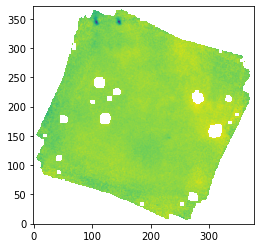

In [26]:
mask_3sigma = make_source_mask(data_ma-bkg, nsigma=3, npixels=3,
                               dilate_size=3, filter_fwhm=3)

data_ma2 = np.ma.masked_array(data, mask=mask_3sigma)

plt.imshow(data_ma2,origin='lower')
plt.show()

In [27]:
#create updated background model detected sources masked
bkg_data = Background2D(data_ma2,(bkgbox,bkgbox),bkg_estimator=bkg_estimator,edge_method='pad')
bkg_rms=bkg_data.background_rms 
bkg=bkg_data.background

#create background subtracted image
data_bkgsub = data - bkg

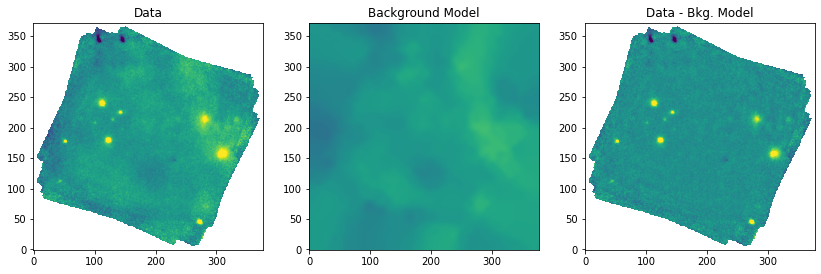

In [28]:
#plot the data and background model
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(14,10))
ax1.set_title('Data')

#set the image limits for the plots
minval=-0.1
maxval=0.1

ax1.imshow(data,origin='lower',vmin=minval,vmax=maxval)
ax2.set_title('Background Model')
ax2.imshow(bkg,origin='lower',vmin=minval,vmax=maxval)
ax3.set_title('Data - Bkg. Model')
ax3.imshow(data_bkgsub,origin='lower',vmin=minval,vmax=maxval)
plt.show()

## Do Photometry - Combined source list

In [29]:
#load in source lists if they exist
if os.path.isfile(field.name+'_'+str(wavelength)+'um_CombinedSources.fits'):
    combTab=Table.read(field.name+'_'+str(wavelength)+'um_CombinedSources.fits')
else:
    combTab=None
    
#Get Source coordinates from table
if combTab is not None:
    sourcesAll=combTab['sky_centroid']

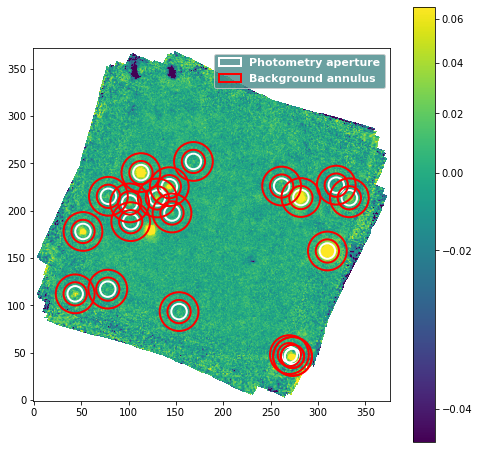

In [33]:
if combTab is not None:
    CombPhotTable=performApPhoto(data_bkgsub,errormap,tmap,header,sourcesAll,radii,r_in,r_out,plot=True)
    
    #add additonal information to table
    CombPhotTable['Field']=field.name
    CombPhotTable['wv']=wavelength

    #display the photometry table
    #CombPhotTable
else:
    print('No sources found in Combined Source List')

In [16]:
#merge Tables
mtComb = join(combTab, CombPhotTable, keys='id')

#add shape parameters to table - skip fitshapes because it is depreciated
mtComb=fitshapes(data_bkgsub,mtComb) #,cutouts=True,cutsize=cutsize) #optional plot=True for diagnostic plots

mtComb=modelSources(data_bkgsub,errormap,mtComb,header,cutouts=True,cutsize=cutsize)

#show table - optional
mtComb

sky_centroid,finder,id,xcentroid,ycentroid,sky_center,aperture_sum_4pix,aperture_sum_err_4pix,aperture_sum_8pix,aperture_sum_err_8pix,aperture_sum_12pix,aperture_sum_err_12pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,texp_med,texp_mean,aper_sum_bkgsub_4pix,aper_4pix_noise,aper_snr_4pix,aper_area_4pix,aper_sum_bkgsub_8pix,aper_8pix_noise,aper_snr_8pix,aper_area_8pix,aper_sum_bkgsub_12pix,aper_12pix_noise,aper_snr_12pix,aper_area_12pix,Field,wv,fit_x_cent,fit_y_cent,fwhm,semimajor_sigma,semiminor_sigma,orientation,elongation,covar_sigx2,covar_sigy2,fit_dist,fit_x0,fit_y0,fit_x0_err,fit_y0_err,fit_amp,fit_gamma,fit_gamma_err,fit_alpha,fit_alpha_err,fit_fwhm,fit_xfwhm,fit_yfwhm,fit_elong,fit_orient,FluxMoffat2D,FluxMoffatErr,ModelSNR,Moffat2DChi2,FluxGauss2D,FluxGauss2DErr,gModelSNR,Gauss2DChi2,FitWarningFlag,"cutouts [25,25]",MoffatChi2RE,GaussChi2RE,BestModel
"deg,deg",,,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,pix,pix,pix,deg,,pix2,pix2,,,,,,,,,,,,,,,,,,,,,,,,,,,,
object,int32,int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str7,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,str1
"266.20473105876266,-29.394990923236342",4,1,199.780723819514,85.4563970379878,"266.20473105876266,-29.394990923236342",3.539514360894844,0.7719018683915059,6.706899091779836,1.5422829019222644,8.183849869358399,2.302733922259468,842.3889206791451,6.71485806633619e-05,0.0001733524990981422,0.004931658902774303,410.9099999999996,410.58015688416145,3.535979034620459,0.7738801385704868,4.569155943389538,52.64930754244658,6.692757786682299,1.543281345470148,4.33670620481932,210.59723016978631,8.152031932888942,2.3034272434417846,3.539088094099366,473.84376788201916,Field47,25,6.89661167896534,6.531529205912368,4.584919728816219,2.2183949740888367,1.631141683935366,-21.072130820967452,1.360025922908571,4.62903904761737,2.9528604065167414,0.6353531611796535,7.829794169850552,8.612130390361495,0.0748764030920422,0.07493122227156453,0.12802079158608634,3.242710852634309,1.5832546328691448,1.2484838175546222,0.21816543215805762,4.291227778155324,6.775526169547107,5.300990775572416,0.7823733010430903,-0.39571964838959894,7.295987437150967,0.09309120765809305,132.16099306884053,0.005020036222457998,6.721333813669012,0.09796948671932733,120.20846487840376,0.006463423457691485,0,0.008687350193826158 .. 0.005658505313031614,1.7918691792050774,2.3070768362539216,M
"266.1866903832937,-29.389531429816437",4,2,273.4628759498442,111.04269814917029,"266.1866903832937,-29.389531429816437",0.5132068205784754,0.7690906032065985,0.6306512132072313,1.5385287096395306,0.4982005354430322,2.308091830680939,842.3889206791451,-1.2126750021107752e-06,0.00012004852030076963,0.004459620458242438,410.9099999999996,410.3394082710829,0.5132706670776106,0.775855717638154,0.6615542753749369,52.64930754244658,0.6309065992037719,1.5459706073322503,0.4080974089749828,210.59723016978631,0.49877515393524874,2.324323987024288,0.214589341554662,473.84376788201916,Field47,25,6.955249455666285,5.623604776969094,5.815702780664639,2.73845042128811,2.1678886172938827,48.12437125887089,1.263187785314563,5.947077107214645,6.2517746596307635,0.6047104627045253,8.59621300478614,8.101018793440643,0.400934295560027,0.40093574094066026,0.035394532863004834,6.542509830363949,1267.446478740529,9.261359485576417,8144.55703796716,2.8014805032988854,3.8427258907531243,2.4400529200493577,0.634979696553672,3.685938192040391,0.5760501780465292,0.03279731240472732,6.7161270614547055,0.0027757112395940154,0.6033701753202999,0.03257449922193129,7.13998223542321,0.002623653264083622,0,0.00197936714

In [17]:
#write out catalog - May want some additional pre-processing before we get here but go ahead and print for now...
mtComb.write(field.name+'_'+str(wavelength)+'um_CombCat.fits', overwrite=True)

## Testing for Model fitting 

In [431]:
from astropy.modeling import models, fitting
import warnings
from astropy.utils.exceptions import AstropyUserWarning

In [432]:
def extractModel(psfmodel, datacutout, unccutout,correctErrors=True):
	#Normalize psfmodel
	psfmodel = psfmodel / np.sum(psfmodel)
	
	#Compute best-fit flux for model
	model_flux = np.sum(psfmodel * datacutout) / np.sum(np.square(psfmodel))
	
	#Compute chi2 of model fit
	deg_freedom = np.size(datacutout) - 1 
	chi2 = np.sum(np.square(datacutout - psfmodel * model_flux) / np.square(unccutout)) / deg_freedom #*100
	
	
	if (correctErrors and chi2<2.0):
		re_unccutout=unccutout*np.sqrt(chi2)
		model_flux_err = np.sqrt(np.sum(np.square(psfmodel) * np.square(re_unccutout)))/ np.sum(np.square(psfmodel))
		#chi2 = np.sum(np.square(datacutout - psfmodel * model_flux) / np.square(re_unccutout)) / deg_freedom    
	else:
		model_flux_err = np.sqrt(np.sum(np.square(psfmodel) * np.square(unccutout)))/ np.sum(np.square(psfmodel))
	    
	return model_flux, model_flux_err, chi2

In [446]:
def modelSources(data,errorimg,tab,header,cutouts=False,cutsize=25):
    csize=17
    xfit=[]
    yfit=[]
    xfiterr=[]
    yfiterr=[]
    amp=[]
    alpha=[]
    alphaerr=[]
    gamma=[]
    gammaerr=[]
    fwhm=[]
    xfwhm=[]
    yfwhm=[]
    elong=[]
    orient=[]
    modelflux=[]
    modelfluxerr=[]
    modelSNRs=[]
    modelchi2=[]
    fitwarn=[]
    gmodelflux=[]
    gmodelfluxerr=[]
    gmodelSNRs=[]
    gmodelchi2=[]
    gfitwarn=[]
    modeltype=[]
    #sourcepixels=[]
    cimages=np.zeros((len(tab),csize,csize))
    residuals=np.zeros((len(tab),csize,csize))
    cutimgs=np.zeros((len(tab),cutsize,cutsize)) #these are the display cutouts
    pcovmatrix=[]
    
    
    i=0
    for source in tab:
        spos=(source['xcentroid'].value,source['ycentroid'].value)
        
        cut_img=Cutout2D(data,spos,csize,mode='partial',fill_value=0.0,copy=True)
        unc_img=Cutout2D(errorimg,spos,csize,mode='partial',fill_value=0.0,copy=True)
        
        cimg=cut_img.data
        uimg=unc_img.data
        
        #Background subtraction based on annulus background
        cimg=cimg-tab['ann_bkg_med'][i] #could do this better with a 2D bkg model... but larger cutout needed.
        
        y, x = np.mgrid[:csize, :csize]
        
        # Fit the data using astropy.modeling
        p1_init = models.Moffat2D(x_0=np.int32(csize/2),y_0=np.int32(csize/2))
        fit_p1 = fitting.LevMarLSQFitter(calc_uncertainties=True)
        
        
        with warnings.catch_warnings(record=True) as w:      
            
            p1 = fit_p1(p1_init, x, y, cimg)
            #print(w[0].message) #debugging to check error messages
            fitwarn.append(len(w))
            

        if p1.cov_matrix is not None:
            p1cov=np.diag(p1.cov_matrix.cov_matrix)
            xfiterr.append(p1cov[1])
            yfiterr.append(p1cov[2])
            gammaerr.append(p1cov[3])
            alphaerr.append(p1cov[4])
            #pcovmatrix.append(p1cov)
            #print(p1cov)
        else:
            xfiterr.append(-1)
            yfiterr.append(-1)
            gammaerr.append(-1)
            alphaerr.append(-1)
            #pcovmatrix.append([-1, -1, -1, -1, -1)
        
        mmodel=p1(x, y)
        resid=cimg.data - mmodel
        
        #residuals[i,:,:]=resid
        #cimages[i,:,:]=cimg
        
        mflux,mfluxerr,chi2m=extractModel(mmodel,cimg,uimg)
        
        
        r_effective=(p1.fwhm)/2.0
        noisecalc=np.sqrt(2*np.pi*(r_effective*tab['ann_bkg_std'][i]/mflux)**2+(header['ERRCALF']/header['CALFCTR'])**2+0.0025+(mfluxerr/mflux)**2)
        modelSNR=mflux/noisecalc
        
        
        p2_init = models.Gaussian2D(x_mean=np.int32(csize/2),y_mean=np.int32(csize/2))
        fit_p2 = fitting.LevMarLSQFitter(calc_uncertainties=True)
        
        with warnings.catch_warnings(record=True) as w2:
            p2 = fit_p2(p2_init, x, y, cimg)
            
            gfitwarn.append(len(w2))
        
        gmodel=p2(x, y)
        gresid=cimg - gmodel
        
        residuals[i,:,:]=gresid
        cimages[i,:,:]=cimg
        
        gflux,gfluxerr,chi2g=extractModel(gmodel,cimg,uimg)
        
        
        r_effective=np.sqrt(p2.x_fwhm*p2.y_fwhm)/2.0
        noisecalc=np.sqrt(2*np.pi*(r_effective*tab['ann_bkg_std'][i]/gflux)**2+(header['ERRCALF']/header['CALFCTR'])**2+0.0025+(gfluxerr/gflux)**2)
        gmodelSNR=gflux/noisecalc
        
        if cutouts:
            c2=Cutout2D(data,spos,cutsize,mode='partial',fill_value=0.0,copy=True)
            cutimgs[i,:,:]=c2
            
                
        #pix_aperture=CircularAperture((p1.x_0.value,p1.y_0.value), r=r_effective*1.2)
        #source_mask = pix_aperture.to_mask(method='exact')
        #source_data = source_mask.multiply(data)
        #sourcedata=source_mask.data
        #ourcepix=sum(sum(sourcedata>5*tab['ann_bkg_std'][i]))
 

        xfit.append(p1.x_0.value)
        yfit.append(p1.y_0.value)
        amp.append(p1.amplitude.value)
        alpha.append(p1.alpha.value)
        gamma.append(p1.gamma.value)
        fwhm.append(p1.fwhm*0.768) # in arcseconds
        xfwhm.append(p2.x_fwhm*0.768) # in arcseconds
        yfwhm.append(p2.y_fwhm*0.768) # in arcseconds
        
        if p2.x_fwhm<p2.y_fwhm:
            elong.append(p2.x_fwhm/p2.y_fwhm)
        else:
            elong.append(p2.y_fwhm/p2.x_fwhm)
        
        orient.append(p2.theta.value)
        modelflux.append(mflux)
        modelfluxerr.append(mfluxerr)
        modelSNRs.append(modelSNR)
        modelchi2.append(chi2m)
        
        gmodelflux.append(gflux)
        gmodelfluxerr.append(gfluxerr)
        gmodelSNRs.append(gmodelSNR)
        gmodelchi2.append(chi2g)
        #sourcepixels.append(sourcepix)
        i=i+1
         

    #elongation
    tab['fit_x0']=xfit
    tab['fit_y0']=yfit
    tab['fit_x0_err']=xfiterr
    tab['fit_y0_err']=yfiterr
    tab['fit_amp']=amp
    tab['fit_gamma']=gamma
    tab['fit_gamma_err']=gammaerr
    tab['fit_alpha']=alpha
    tab['fit_alpha_err']=alphaerr
    tab['fit_fwhm']=fwhm
    tab['fit_xfwhm']=xfwhm
    tab['fit_yfwhm']=yfwhm
    tab['fit_elong']=elong
    tab['fit_orient']=orient
    tab['FluxMoffat2D']=modelflux
    tab['FluxMoffatErr']=modelfluxerr
    tab['ModelSNR']=modelSNRs
    tab['Moffat2DChi2']=modelchi2
    tab['FluxGauss2D']=gmodelflux
    tab['FluxGauss2DErr']=gmodelfluxerr
    tab['gModelSNR']=gmodelSNRs
    tab['Gauss2DChi2']=gmodelchi2
    tab['FitWarningFlag']=fitwarn
    #tab['SourcePix']=sourcepixels
    tab['DataCutout']=cimages
    tab['ModelResidual']=residuals
    tab['cutouts']=cutimgs
    #tab['Model_pcov']=pcovmatrix
    
    scstats=sigma_clipped_stats(modelchi2)
    rescl=scstats[1]+3*scstats[2]
    if rescl<0.7:
        tab['MoffatChi2RE']=np.array(modelchi2)/rescl
    else:
        tab['MoffatChi2RE']=np.array(modelchi2)
    
    scstats=sigma_clipped_stats(gmodelchi2)
    rescl=scstats[1]
    if rescl<0.5:
        tab['GaussChi2RE']=np.array(gmodelchi2)/rescl
    else:
        tab['GaussChi2RE']=np.array(gmodelchi2)
    
    #classify models
    for source in tab:
        if source['MoffatChi2RE']<=2.0:
            mtype='M'
            #residuals[j,:,:]=resid
        elif source['GaussChi2RE']<=2.0:
            mtype='G'
            #residuals[j,:,:]=gresid
        else:
            mtype='A'
                
        modeltype.append(mtype)
        
    tab['BestModel']=modeltype
    
    return tab

In [447]:
newtab=modelSources(data_bkgsub,errormap,mtComb,header)

In [448]:
newtab

sky_centroid,finder,id,xcentroid,ycentroid,sky_center,aperture_sum_4pix,aperture_sum_err_4pix,aperture_sum_8pix,aperture_sum_err_8pix,aperture_sum_12pix,aperture_sum_err_12pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,texp_med,texp_mean,aper_sum_bkgsub_4pix,aper_4pix_noise,aper_snr_4pix,aper_area_4pix,aper_sum_bkgsub_8pix,aper_8pix_noise,aper_snr_8pix,aper_area_8pix,aper_sum_bkgsub_12pix,aper_12pix_noise,aper_snr_12pix,aper_area_12pix,Field,wv,fit_x_cent,fit_y_cent,fwhm,semimajor_sigma,semiminor_sigma,orientation,elongation,covar_sigx2,covar_sigy2,fit_dist,"cutouts [25,25]",fit_x0,fit_y0,fit_x0_err,fit_y0_err,fit_amp,fit_gamma,fit_gamma_err,fit_alpha,fit_alpha_err,fit_fwhm,fit_xfwhm,fit_yfwhm,fit_elong,fit_orient,FluxMoffat2D,FluxMoffatErr,ModelSNR,Moffat2DChi2,FluxGauss2D,FluxGauss2DErr,gModelSNR,Gauss2DChi2,FitWarningFlag,"DataCutout [17,17]","ModelResidual [17,17]",MoffatChi2RE,GaussChi2RE,BestModel
"deg,deg",,,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,pix,pix,pix,deg,,pix2,pix2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
object,int32,int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str7,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,str1
"266.02006908793686,-29.42252156100146",4,1,304.08524638562346,155.63705929836138,"266.02006908793686,-29.42252156100146",2.5760028473996526,0.7388482492551434,6.8505004371256035,1.4782939711542076,10.663592012085637,2.2259815969847634,842.388794604481,0.0026863798319944495,0.003735846324101938,0.006266794903536402,478.2879500000003,477.17079629063784,2.434566830616928,0.7413675475251154,3.283886432234818,52.649299662780045,6.284756369994705,1.4794647297790249,4.247993374558788,210.59719865112018,9.390667861041116,2.2267599787483405,4.217189077701855,473.84369696502046,Field47,25,6.789256535951098,6.486826776801606,5.239211671774341,2.3295075981468045,2.115100622163952,-33.992982034364694,1.1013696340193468,5.128727979914124,4.771528311787907,0.2895563458117666,0.0 .. 0.0,8.95089321542583,7.602731975742652,0.3107118409242297,0.3067801578403638,0.0606484193015969,5.017511681974512,13.624116347046138,0.9755659818854526,0.5884420351412637,7.8407006346614985,10.641900921048418,8.896373011369226,0.8359759292414812,2.6448630502220736,7.421593824439629,0.09978606235368351,128.0250079982572,0.004048273079035999,7.339707344804102,0.1029340420791664,125.07771289730783,0.004384942447248356,0,0.003113110892345359 .. 0.006603624946910289,-0.00015478895353567305 .. 0.0020073104161567913,0.580242107983211,1.341839229831342,M
"266.0446602894267,-29.42060261184013",4,2,203.681699589575,164.64405411028673,"266.0446602894267,-29.42060261184013",3.1953390316786723,0.7019942720820366,6.112953494405337,1.407382006496064,7.545782610468958,2.1192130046985933,842.388794604481,0.00046169745744071666,0.000727525997864416,0.004028578272253974,575.4245000000004,570.309032028889,3.1710309838883326,0.7042877306465203,4.502465179930648,52.649299662780045,6.015721303243978,1.4085337920670662,4.270910174200169,210.59719865112018,7.327010180355899,2.1200000646737913,3.456136772091712,473.84369696502046,Field47,25,6.535463693008904,6.1392842258682645,4.866999577535875,2.4571083596015972,1.5830808218769685,54.77547573142132,1.5521054425309404,3.680907869797761,4.862618509620948,0.3624548844053381,0.0 .. 0.0,7.532601491313394,7.314380158438975,0.0932204858871955,0.09329759763458907,0.1024019764497348,4.36487325467456,3.9586559081597397,1.6118595061621301,0.7067899565083171,4.9144220530508775,7.22959007210257,5.066265809089104,0.7007680599538736,4.08152198002885,6.547640012059998,0.08635788062483762,114.654

In [449]:
#plt.hist(newtab['Moffat2DChi2'])

In [450]:
#sigma_clipped_stats(newtab['Moffat2DChi2'])

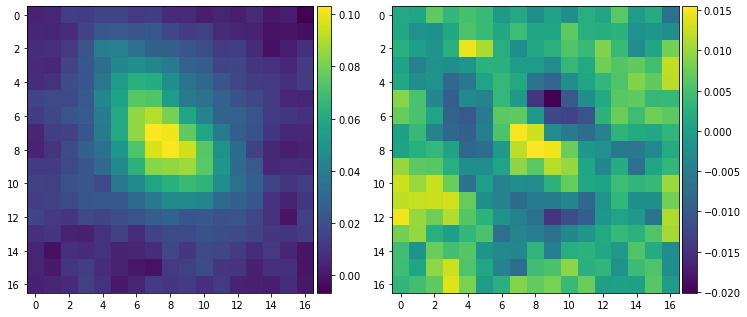

In [451]:
sourcenumber=1
fig, (ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
im1=ax1.imshow(newtab['DataCutout'][sourcenumber])

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical');


im2=ax2.imshow(newtab['ModelResidual'][sourcenumber])

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical');
#plt.colorbar()

In [452]:
newtab['Moffat2DChi2'][sourcenumber]

0.005120974050085278

In [453]:
newtab['MoffatChi2RE'][sourcenumber]

0.7339931668978155

In [454]:
#500 - field 8 scaling and 9 and 44

In [455]:
newtab['Gauss2DChi2'][sourcenumber]

0.004174407447265415

## Do Photometry - Only Segment Map Sources (optional)

In [ ]:
#get seg table from detection step
if os.path.isfile(field.name+'_'+str(wavelength)+'um_seg.fits'):
    segTab=Table.read(field.name+'_'+str(wavelength)+'um_seg.fits')
else:
    segTab=None

#Get Source coordinates from table
if segTab is not None:
    sourcesseg=segTab['sky_centroid']

In [ ]:
if segTab is not None:
    SegPhotTable=performApPhoto(data_bkgsub,tmap,wcsmap,sourcesseg,radii,r_in,r_out,plot=True)

    #display the photometry table
    #SegPhotTable
else:
    print('No sources found in segmentation map')

In [ ]:
#fix id keywords in Seg table so they can be merged
try:
    segTab.rename_column('label', 'id')
except:
    print('Do nothing because keyword is already changed.')

In [ ]:
#merge Tables
mtSeg = join(segTab, SegPhotTable, keys='id')

#add shape parameters to table
mtSeg=fitshapes(data_bkgsub,mtSeg) #optional plot=True for diagnostic plots

#display seg table
mtSeg

In [ ]:
#write out the resulting tables to file
mtSeg.write(field.name+'_'+str(wavelength)+'um_segCat.fits',overwrite=True)

## Do Photometry - Only DAO Sources (optional)

In [ ]:
if os.path.isfile(field.name+'_'+str(wavelength)+'um_dao.fits'):   
    daoTab=Table.read(field.name+'_'+str(wavelength)+'um_dao.fits')
else:
    daoTab=None
    
if daoTab is not None:
    sourcesdao=daoTab['sky_centroid']

In [ ]:
if daoTab is not None:
    DaoPhotTable=performApPhoto(data_bkgsub,tmap,wcsmap,sourcesdao,radii,r_in,r_out,plot=True)

    #display the photometry table
    #DaoPhotTable
else:
    print('No sources found by DAOfind map')

In [ ]:
#merge Tables
mtDao = join(daoTab, DaoPhotTable, keys='id')

#add shape parameters to table
mtDao=fitshapes(data_bkgsub,mtDao) #optional plot=True for diagnostic plots

#optional - show Dao table
#mtDao

In [ ]:
#write out the resulting tables to file
mtDao.write(field.name+'_'+str(wavelength)+'um_daoCat.fits',overwrite=True)